# $\frac{dE}{d\eta}$ Model

## Training

In [1]:
import sys
sys.path.append('../hydroml')

from hydroml.model import DELinearModel, DEConvolutionModel
from hydroml.dataset import EnergyDensityDataset
from hydroml.utils import batch_trim, trim
from hydroml.plot import plot_cc_graph
from torch import nn
from IPython import display

import numpy as np

import torch

In [2]:
dataset = EnergyDensityDataset('../Datasets/dE_data/dE_detas_initial', '../Datasets/dE_data/dNch_deta_final')

In [3]:
batch_size = 64
ngpu = 0
epochs = 1000
learning_rate = 1e-4
beta1 = 0.9

In [4]:
data_loader = torch.utils.data.DataLoader(
    dataset=dataset,
    batch_size=batch_size,
    shuffle=True,
)

In [5]:
dE_model = DEConvolutionModel()

In [6]:
optimizer = torch.optim.Adamax(dE_model.parameters(), lr=learning_rate)

In [7]:
loss_func = nn.MSELoss()

In [8]:
for epoch in range(epochs):
    for i, data in enumerate(data_loader):
        actual_batch_size = data[1].shape[0]

        etas_start = dataset.start_eta
        etas_final = dataset.final_eta
        dE_deta_initial = data[0].reshape(actual_batch_size,1, len(dataset.start_eta))
        dNch_deta_final = data[1].reshape(actual_batch_size, 1, len(dataset.final_eta))

        etas_final_trim, dNch_deta_final_trim = batch_trim(etas_final, dNch_deta_final, -4.9, -4.0)

        optimizer.zero_grad()

        output = dE_model(dE_deta_initial.float())

        loss = loss_func(output, dNch_deta_final_trim)

        loss.backward()
        optimizer.step()

        display.clear_output(wait=True)
        #plot.plot_telemetry(output.detach().numpy(), dNch_deta_final, etas)

        print(f"Epoch [{epoch+1}/{epochs}], Batch [{i+1}/{len(dataset) // batch_size}], loss: {loss:.4f}")

Epoch [500/500], Batch [79/78], loss: 7.0956


In [9]:
torch.save(dE_model, '../Trained Models/dE_model.pt')

# Inference

In [10]:
dE_detas_model = torch.load('../Trained Models/dE_model.pt')
dE_detas_model.eval()

DEConvolutionModel(
  (conv1): Conv1d(1, 1, kernel_size=(16,), stride=(1,))
  (lin3): Linear(in_features=49, out_features=9, bias=True)
)

In [11]:
bound_1 = -4.9
bound_2 = -4.0

In [12]:
data_loader = torch.utils.data.DataLoader(
    dataset=dataset,
    shuffle=True,
)

[13.40634307  1.65738929  6.03945769 ...  3.84774288  6.74456367
 12.88150668]
[12.44996958  1.38826438  6.23764645 ...  2.67974511  7.9714421
 10.99125992]


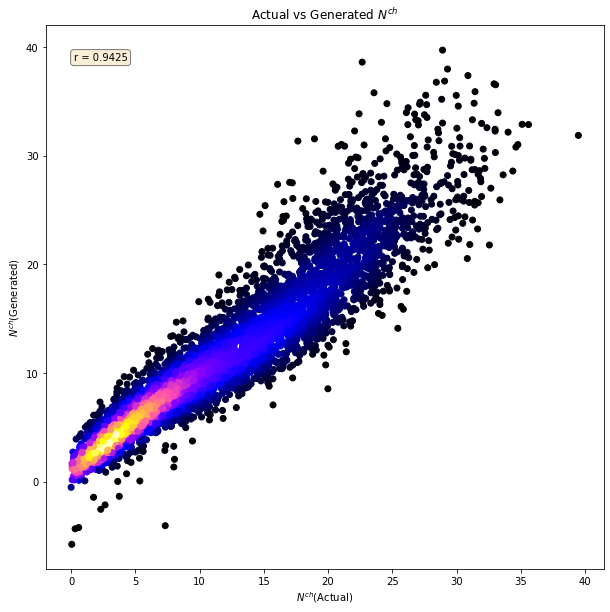

In [13]:
finals = []
models = []

for i, data in enumerate(data_loader):
    dE_detas_initial = data[0]
    dNch_detas_final = data[1]

    output = dE_detas_model(dE_detas_initial.float())

    x_axis, dNch_detas_final_trim = trim(dataset.final_eta, dNch_detas_final.flatten(), bound_1, bound_2)
    #_, output_trim = trim(dataset.final_eta, output.detach().numpy(), bound_1, bound_2)

    integrated_final = np.trapz(dNch_detas_final_trim, x_axis)
    integrated_output = np.trapz(output.detach().numpy().flatten(), x_axis)

    finals.append( integrated_final )
    models.append( integrated_output )

finals = np.array(finals)
models = np.array(models)
plot_cc_graph(finals, models)